# WGAN-GP for Stable Battery Data Generation

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
from torch.autograd import grad

In [2]:
# Simulate battery-like sequences
np.random.seed(42)
n_samples = 500
X = np.array([
    np.sin(np.linspace(0, 2*np.pi, 50)) + np.random.normal(0, 0.1, 50)
    for _ in range(n_samples)
])
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
tensor_data = torch.tensor(X_scaled, dtype=torch.float32)

In [3]:
# Dataset and loader
class TempDataset(Dataset):
    def __init__(self, data): self.data = data
    def __len__(self): return len(self.data)
    def __getitem__(self, idx): return self.data[idx]

loader = DataLoader(TempDataset(tensor_data), batch_size=32, shuffle=True)

In [4]:
# Generator and Critic definitions
class Generator(nn.Module):
    def __init__(self, noise_dim, output_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )
    def forward(self, z):
        return self.model(z)

class Critic(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1)
        )
    def forward(self, x):
        return self.model(x)

In [5]:
# Gradient penalty

def compute_gp(critic, real, fake):
    alpha = torch.rand(real.size(0), 1)
    alpha = alpha.expand_as(real)
    interpolated = alpha * real + (1 - alpha) * fake
    interpolated.requires_grad_(True)
    prob = critic(interpolated)
    gradients = grad(outputs=prob, inputs=interpolated,
                    grad_outputs=torch.ones_like(prob),
                    create_graph=True, retain_graph=True)[0]
    return ((gradients.norm(2, dim=1) - 1) ** 2).mean()

In [6]:
# Training loop
G = Generator(20, 50)
C = Critic(50)
opt_G = optim.Adam(G.parameters(), lr=1e-4, betas=(0.0, 0.9))
opt_C = optim.Adam(C.parameters(), lr=1e-4, betas=(0.0, 0.9))

G_losses, C_losses = [], []
lambda_gp = 10

for epoch in range(10):
    for real in loader:
        z = torch.randn(real.size(0), 20)
        fake = G(z).detach()
        gp = compute_gp(C, real, fake)

        loss_C = -(C(real).mean() - C(fake).mean()) + lambda_gp * gp
        opt_C.zero_grad()
        loss_C.backward()
        opt_C.step()

        z = torch.randn(real.size(0), 20)
        gen = G(z)
        loss_G = -C(gen).mean()
        opt_G.zero_grad()
        loss_G.backward()
        opt_G.step()

        G_losses.append(loss_G.item())
        C_losses.append(loss_C.item())

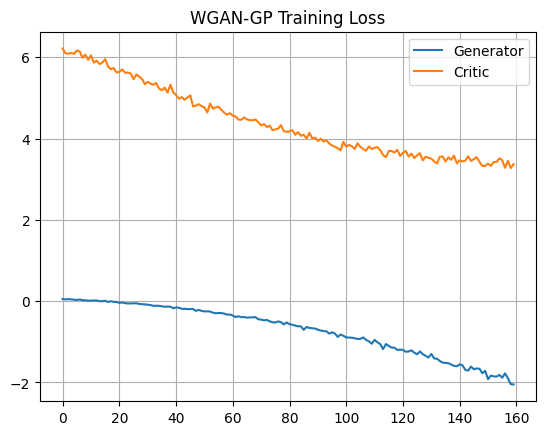

In [7]:
# Loss plot
plt.plot(G_losses, label='Generator')
plt.plot(C_losses, label='Critic')
plt.legend()
plt.title('WGAN-GP Training Loss')
plt.grid(True)
plt.show()

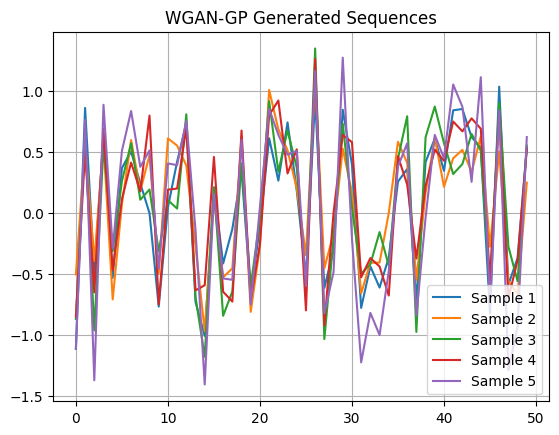

In [9]:
# Generate and visualize
z = torch.randn(5, 20)
samples = G(z).detach().numpy()
for i, s in enumerate(samples):
    plt.plot(s, label=f'Sample {i+1}')
plt.title('WGAN-GP Generated Sequences')
plt.legend()
plt.grid(True)
plt.show()